# Geospatial Analysis of Crash Cases in Philadelphia from 2010 - 2021

This data is aggregated by Police District.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas

In [76]:
# Spatial Plot
philly_map = geopandas.read_file("./Boundaries_District/Boundaries_District.shp")
philly_map_2 = philly_map.copy()

# Crash Dataset
df = pd.read_csv("./APAC_2023_Datasets/Crashes/crash_info_general.csv")


/var/folders/5n/7955wqx52_s2p0fymgbx_vsh0000gn/T/ipykernel_83077/508891809.py:6: DtypeWarning: Columns (97,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/pongyizhen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Y2S2_Citadel comps/APAC_2023_Datasets/Crashes/crash_info_general.csv")


In [77]:
#add binary column for small automobile count
df['small_automobiles'] = (df['BICYCLE_COUNT']).apply(lambda x: 1 if x > 0 else 0)

In [78]:
# Create GeoSpatial DataFrame
crashes_coords = geopandas.GeoDataFrame(
    df,
    geometry=geopandas.points_from_xy(df['DEC_LONG'], df['DEC_LAT'])
)

In [79]:
# Map to district
crashes_coords['DISTRICT_'] = ''
for idx in range(philly_map.shape[0]):
    pip = crashes_coords.within(philly_map.loc[idx, 'geometry'])
    if pip.sum() > 0:
        crashes_coords.loc[pip, 'DISTRICT_'] = philly_map.loc[idx, 'DISTRICT_']
  

In [80]:
#Filter out invalid cases that do not fall within the districts
crashes_coords = crashes_coords[crashes_coords['DISTRICT_'] != '']


In [81]:
#group by district and count, before filtering for heavy vehicles
stats_before_filter = crashes_coords.groupby(['DISTRICT_'])[['CRN']].count()

print(stats_before_filter)

             CRN
DISTRICT_       
1           3333
2           6270
3           6475
5           1999
6           6995
7           4272
8           7706
9           4967
12          8005
14          5866
15         12130
16          8840
17          2537
18          7567
19          4887
22          6135
24          6893
25          7485
26          5183
35          7089
39          6890
77            44


In [82]:
# Filter cases with small automobiles
crashes_coords = crashes_coords[crashes_coords['small_automobiles'] == 1]

In [83]:
#Group by district and count
stats = crashes_coords.groupby(['DISTRICT_'])[['CRN']].count()

stats = stats.sort_values(by="CRN", ascending=False)
print(stats)

           CRN
DISTRICT_     
3          571
18         527
6          433
9          382
22         341
15         295
25         279
26         268
17         267
16         253
24         223
12         198
19         186
35         173
2          161
39         140
1          132
14         121
8          114
5           85
7           61


In [84]:
stats_ratio = stats.merge(stats_before_filter, on = 'DISTRICT_')
stats_ratio = stats_ratio.reset_index()
stats_ratio['ratio'] = stats_ratio['CRN_x']/ stats_ratio['CRN_y']


stats_ratio = stats_ratio.sort_values(by="ratio", ascending=False)
print(stats_ratio)

    DISTRICT_  CRN_x  CRN_y     ratio
8          17    267   2537  0.105242
0           3    571   6475  0.088185
3           9    382   4967  0.076908
1          18    527   7567  0.069645
2           6    433   6995  0.061901
4          22    341   6135  0.055583
7          26    268   5183  0.051708
19          5     85   1999  0.042521
16          1    132   3333  0.039604
12         19    186   4887  0.038060
6          25    279   7485  0.037275
10         24    223   6893  0.032352
9          16    253   8840  0.028620
14          2    161   6270  0.025678
11         12    198   8005  0.024735
13         35    173   7089  0.024404
5          15    295  12130  0.024320
17         14    121   5866  0.020627
15         39    140   6890  0.020319
18          8    114   7706  0.014794
20          7     61   4272  0.014279


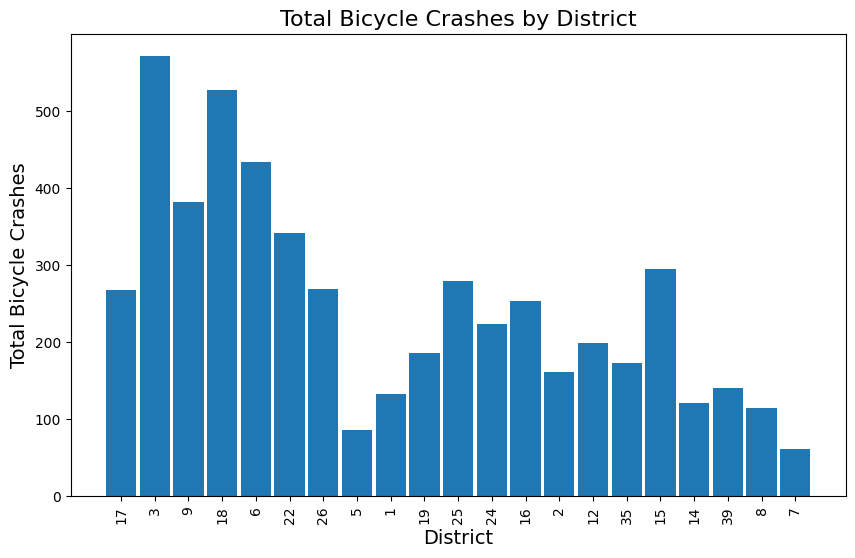

In [85]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(10,6))
stats_ratio_copy = stats_ratio.copy()
stats_ratio_copy['DISTRICT_'] = stats_ratio_copy['DISTRICT_'].astype(str)
#stats_ratio = stats_ratio.sort_values(by="CRN_x", ascending=False)

# create a bar plot with district on x-axis and CRN_x on y-axis
bar_plot = ax.bar(stats_ratio_copy['DISTRICT_'], stats_ratio_copy['CRN_x'], width=0.9)

# set plot title and axis labels
ax.set_title('Total Bicycle Crashes by District', fontsize=16)
ax.set_xlabel('District', fontsize=14)
ax.set_ylabel('Total Bicycle Crashes', fontsize=14)

# rotate x-axis labels for better readability
plt.xticks(rotation=90)

# display the plot
plt.show()

In [86]:
# Merge count into map
map_and_stats = philly_map.merge(stats, on='DISTRICT_')

(-75.2965363338824, -74.939522217298, 39.853475402027584, 40.15148900478962)

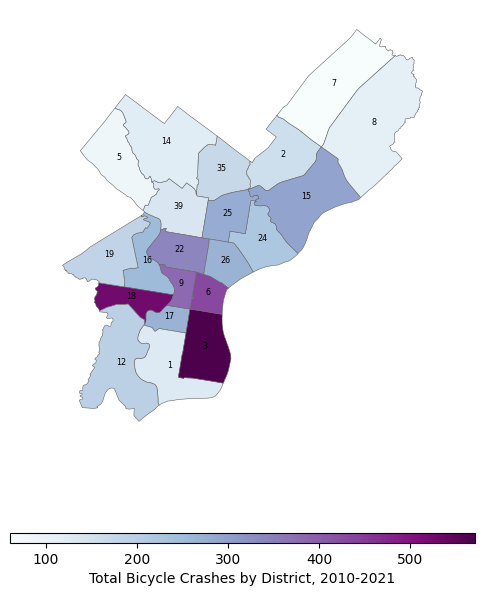

In [87]:
fig, ax = plt.subplots(1, figsize=(12,8))
plt.xticks(rotation=90)
map_and_stats.plot(
    column='CRN',
    cmap='BuPu',
    linewidth=0.4,
    ax=ax,
    edgecolor='.4',
    legend=True,
    legend_kwds={
        'label': "Total Bicycle Crashes by District, 2010-2021",
        'orientation': 'horizontal',
        'shrink': 0.5,
        'aspect': 50
    }
)
map_and_stats.apply(lambda x: ax.annotate(text=x['DIST_NUM'], xy=x.geometry.centroid.coords[0], ha='center', fontsize='xx-small'), axis=1)
ax.axis('off')

In [88]:
# Merge count into map if we using stats ratio
map_and_stats2 = philly_map_2.merge(stats_ratio, on='DISTRICT_')

(-75.2965363338824, -74.939522217298, 39.853475402027584, 40.15148900478962)

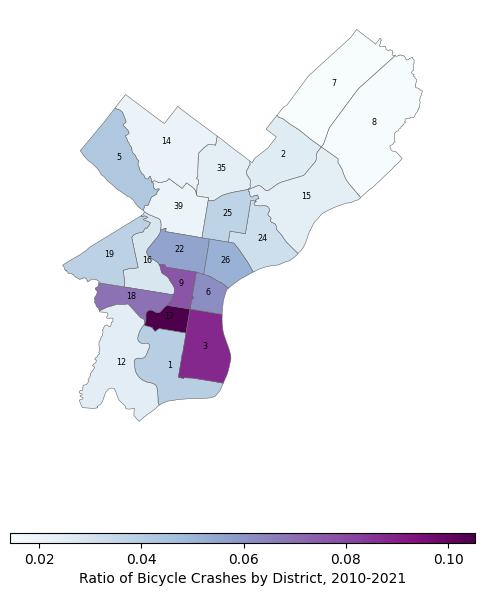

In [89]:
fig, ax = plt.subplots(1, figsize=(12,8))
plt.xticks(rotation=90)
map_and_stats2.plot(
    column='ratio',
    #column='CRN',
    cmap='BuPu',
    linewidth=0.4,
    ax=ax,
    edgecolor='.4',
    legend=True,
    legend_kwds={
        'label': "Ratio of Bicycle Crashes by District, 2010-2021",
        'orientation': 'horizontal',
        'shrink': 0.5,
        'aspect': 50
    }
)
map_and_stats2.apply(lambda x: ax.annotate(text=x['DIST_NUM'], xy=x.geometry.centroid.coords[0], ha='center', fontsize='xx-small'), axis=1)
ax.axis('off')